In [1]:
import numpy as np
import pandas as pd

import fatf
import fatf.utils.data.datasets as fatf_datasets
from sklearn.neural_network import MLPClassifier as NN
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

import itertools as it
from supp import sample
# Fix random seed
fatf.setup_random_seed(42)

21-Nov-02 22:12:19 fatf         INFO     Seeding RNGs using the input parameter.
21-Nov-02 22:12:19 fatf         INFO     Seeding RNGs with 42.


In [2]:
def filter_keys(index, value, d):
    return [
        key
        for key in d.keys()
        if key[index] == value
    ]

In [3]:

# Load data
iris_data_dict = fatf_datasets.load_iris()
iris_X = iris_data_dict['data']
iris_y = iris_data_dict['target']
iris_feature_names = iris_data_dict['feature_names'].tolist()
iris_class_names = iris_data_dict['target_names'].tolist()

# Train a model
# clf = fatf_models.KNN()
clf = NN(max_iter=5000)
clf.fit(iris_X, iris_y)

MLPClassifier(max_iter=5000)

In [4]:
def get_explainers(x, predict_fn, surrogate_model, kwargs_list, attributes, radii):
    surrogates = {}
    for r in radii:
        sample_x = sample(x, r, 1000)
        sample_y = predict_fn(sample_x)
        
        for kwargs in kwargs_list:
            surrogate = surrogate_model(**kwargs).fit(sample_x, sample_y)
            out = {
                'surrogate': surrogate,
                'score': surrogate.score(sample_x, sample_y),
            }
            
            for attr_name, attr in attributes.items():
                out[attr_name] = attr(surrogate)
                
            surrogates[tuple([r]+list(kwargs.values()))] = out
    return surrogates

In [5]:
complexity_attributes = {
    'depth': lambda x: x.get_depth(),
    'n_leaves': lambda x: x.get_n_leaves(),
    'fis': lambda x: x.feature_importances_,
}

parameters = {
    'max_depth': [3, 4, 5],
}

radii = np.linspace(0.5, 5, 10)

kwargs_list = [
    dict(zip(parameters.keys(), _tuple))
    for _tuple in it.product(*parameters.values())
]

subject = iris_X[[0], :]

In [6]:
out = get_explainers(
    subject,
    clf.predict,
    DecisionTreeClassifier,
    kwargs_list,
    complexity_attributes,
    radii
)

In [10]:
df = pd.DataFrame(
    {k: v for k, v in out[key].items() if k not in ['surrogate']}
    for key in filter_keys(1, 3, out)
)
df.set_index(radii, inplace=True)

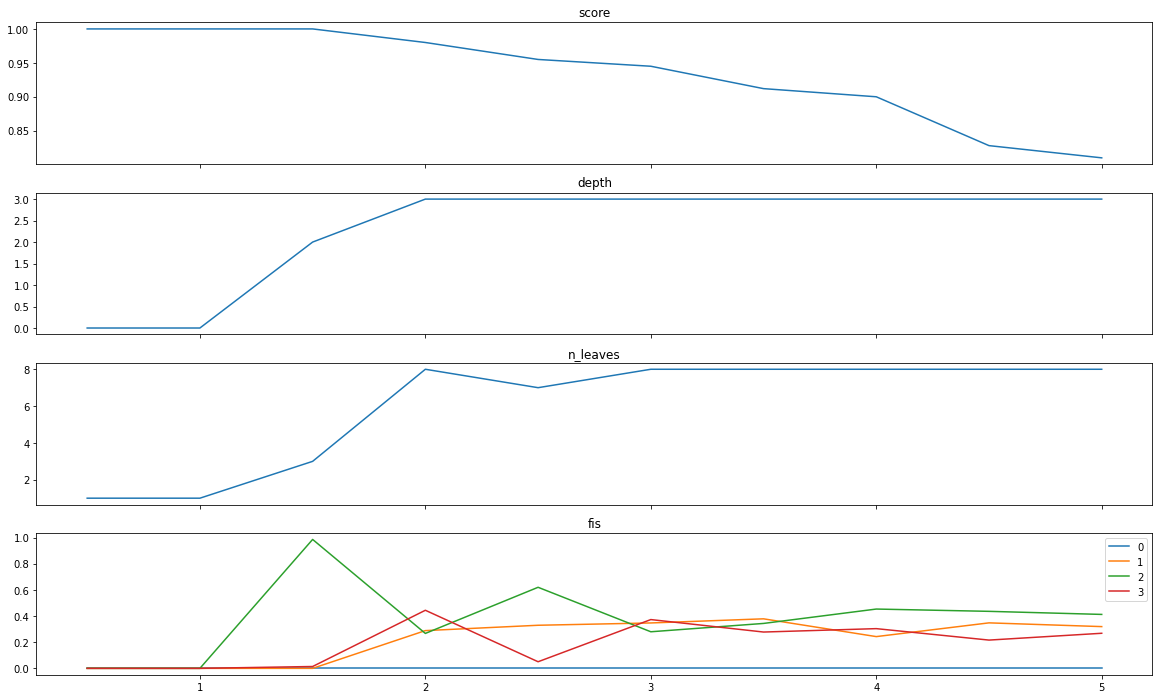

In [16]:
n_ftrs = len(df.columns)
fig, axes = plt.subplots(ncols=1, nrows=n_ftrs, figsize=(20, n_ftrs*3), sharex=True)
for idx, col in enumerate(df.columns):
    ax=axes[idx]
    if col in ['fis']:
        ndf = pd.DataFrame(df['fis'].to_list())
        ndf.set_index(radii, inplace=True)
        ndf.plot(ax=ax)
    else:
        df[col].plot(ax=ax)
        
    ax.set_title(col)

In [15]:
ndf

,0,1,2,3
0,0.0,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000
2,0.0,0.000000,0.985834,0.014166
3,0.0,0.288668,0.267130,0.444202
4,0.0,0.329535,0.619915,0.050550
5,0.0,0.347170,0.279777,0.373053
6,0.0,0.378759,0.343513,0.277728
7,0.0,0.242799,0.453470,0.303731
8,0.0,0.347866,0.435964,0.216170
9,0.0,0.319250,0.412466,0.268284
